In [4]:
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


time_index = pd.date_range(start='2025-01-01', periods=1000, freq='T') 
cpu_usage = np.random.normal(loc=30, scale=10, size=1000) 
cpu_usage = np.clip(cpu_usage, 0, 100)  

spike_indices = np.random.choice(np.arange(1000), size=20, replace=False)
cpu_usage[spike_indices] = cpu_usage[spike_indices] + np.random.randint(50, 80, size=20)
cpu_usage = np.clip(cpu_usage, 0, 100)


df = pd.DataFrame({
    'timestamp': time_index,
    'cpu_usage': cpu_usage
})
df['anomaly'] = 0
df.loc[spike_indices, 'anomaly'] = 1  



/tmp/ipykernel_6684/637866133.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start='2025-01-01', periods=1000, freq='T')


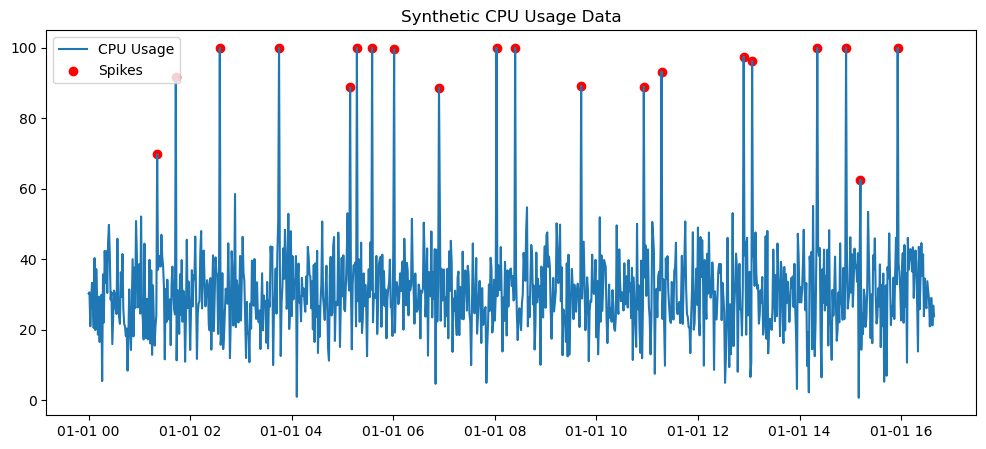

Synthetic dataset created: synthetic_cpu_data.csv


In [6]:
plt.figure(figsize=(12,5))
plt.plot(df['timestamp'], df['cpu_usage'], label='CPU Usage')
plt.scatter(df[df['anomaly']==1]['timestamp'], df[df['anomaly']==1]['cpu_usage'], color='red', label='Spikes')
plt.legend()
plt.title('Synthetic CPU Usage Data')
plt.show()

df.to_csv("synthetic_cpu_data.csv", index=False)
print("Synthetic dataset created: synthetic_cpu_data.csv")

In [7]:
import pandas as pd

data = pd.read_csv("synthetic_cpu_data.csv")
data.head()

,timestamp,cpu_usage,anomaly
0,2025-01-01 00:00:00,30.286626,0
1,2025-01-01 00:01:00,30.640452,0
2,2025-01-01 00:02:00,21.017649,0
3,2025-01-01 00:03:00,28.024227,0
4,2025-01-01 00:04:00,33.327367,0


In [8]:
data['anomaly'].value_counts()

anomaly
0    980
1     20
Name: count, dtype: int64

In [9]:
data.isnull().sum()

timestamp    0
cpu_usage    0
anomaly      0
dtype: int64

In [10]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['is_night'] = data['hour'].between(0, 6).astype(int)  # 12am-6am

features = ['cpu_usage', 'hour', 'is_night']
X = data[features]
y = data['anomaly']

In [11]:
data_featured = data.drop(['timestamp'], axis=1)
data_featured.head()

,cpu_usage,anomaly,hour,is_night
0,30.286626,0,0,1
1,30.640452,0,0,1
2,21.017649,0,0,1
3,28.024227,0,0,1
4,33.327367,0,0,1


In [12]:
data['cpu_lag_1'] = data['cpu_usage'].shift(1)  # Previous minute
data['cpu_rolling_mean_5'] = data['cpu_usage'].rolling(5).mean()

In [13]:
data_featured

,cpu_usage,anomaly,hour,is_night
0,30.286626,0,0,1
1,30.640452,0,0,1
2,21.017649,0,0,1
3,28.024227,0,0,1
4,33.327367,0,0,1
...,...,...,...,...
995,28.885901,0,16,0
996,29.023326,0,16,0
997,21.239621,0,16,0
998,26.853780,0,16,0


In [14]:
X = data_featured.drop('anomaly', axis=1)
y = data_featured['anomaly']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  
)

model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)


print("Random Forest Results:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00         4

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
[[196   0]
 [  0   4]]


/tmp/ipykernel_6684/3468497945.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start='2025-01-01', periods=10080, freq='T')  # 7 days * 24 hours * 60 min


DATASET STATISTICS
Total samples: 10080
Anomalies: 605 (60.50%)

CPU Usage Statistics:
  Overall Mean: 24.69%
  Overall Std: 12.68%
  Normal Mean: 22.49%
  Anomaly Mean: 59.17%
  Min: 0.39%
  Max: 100.00%


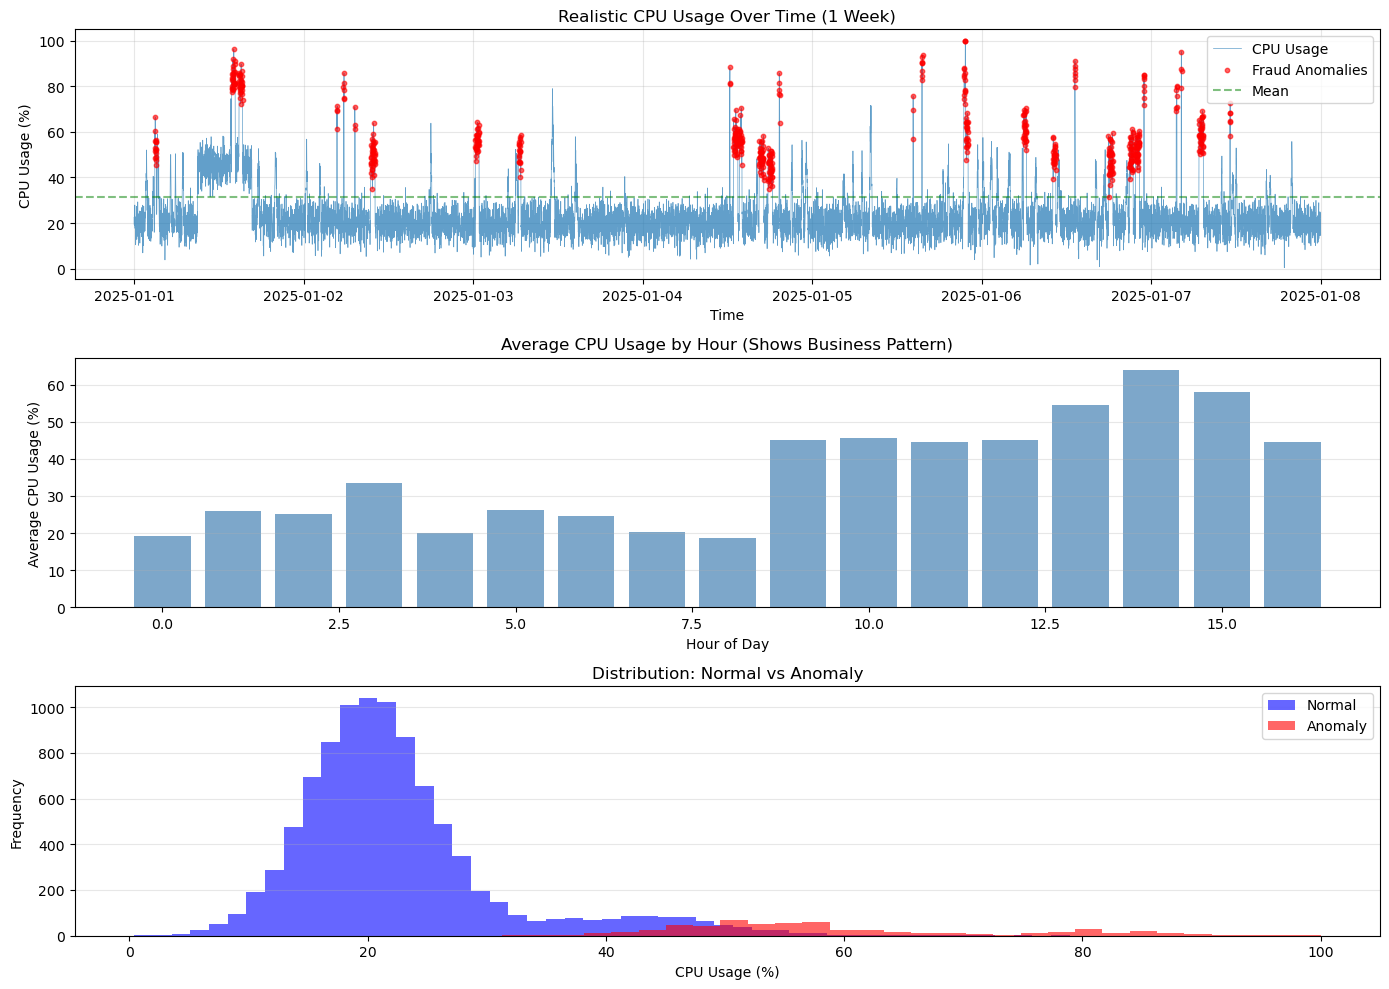


✅ Realistic dataset saved: realistic_cpu_data.csv
✅ Visualization saved: realistic_cpu_analysis.png

Ready for training! 🚀


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate timestamps (1 week of minute-level data)
time_index = pd.date_range(start='2025-01-01', periods=10080, freq='T')  # 7 days * 24 hours * 60 min

# Initialize base CPU usage
n_samples = len(time_index)
cpu_usage = np.zeros(n_samples)

# Create realistic patterns
data = pd.DataFrame({'timestamp': time_index})
data['hour'] = df['timestamp'].dt.hour
data['day_of_week'] = df['timestamp'].dt.dayofweek
data['minute'] = df['timestamp'].dt.minute

# 1. Base load varies by time of day (realistic business patterns)
for i in range(n_samples):
    hour = data.loc[i, 'hour']
    day = data.loc[i, 'day_of_week']
    
    # Business hours (9-17) have higher load
    if 9 <= hour <= 17:
        base_load = 45
    # Evening shopping (18-22)
    elif 18 <= hour <= 22:
        base_load = 35
    # Night time (low activity)
    else:
        base_load = 20
    
    # Weekend modifier (lower traffic)
    if day >= 5:  # Saturday, Sunday
        base_load *= 0.7
    
    cpu_usage[i] = base_load

# 2. Add normal variation/noise
cpu_usage += np.random.normal(0, 5, n_samples)

# 3. Add realistic normal peaks (flash sales, product launches)
normal_peak_indices = np.random.choice(np.arange(n_samples), size=50, replace=False)
for idx in normal_peak_indices:
    # Normal peaks are moderate and gradual
    peak_duration = np.random.randint(10, 30)  # 10-30 minutes
    peak_height = np.random.randint(15, 30)
    
    for offset in range(peak_duration):
        if idx + offset < n_samples:
            # Gradual rise and fall (bell curve-like)
            position = offset / peak_duration
            multiplier = np.sin(position * np.pi)  # Creates smooth rise/fall
            cpu_usage[idx + offset] += peak_height * multiplier

# 4. Inject realistic fraud anomalies
fraud_indices = []
n_fraud_events = 30

for _ in range(n_fraud_events):
    fraud_start = np.random.randint(0, n_samples - 60)
    
    # Fraud type 1: Sudden spike (50% chance)
    if np.random.random() < 0.5:
        spike_duration = np.random.randint(3, 10)  # Short burst
        spike_height = np.random.randint(40, 70)
        
        for offset in range(spike_duration):
            if fraud_start + offset < n_samples:
                cpu_usage[fraud_start + offset] += spike_height
                fraud_indices.append(fraud_start + offset)
    
    # Fraud type 2: Sustained high load (credential stuffing)
    else:
        sustained_duration = np.random.randint(15, 45)  # Longer duration
        sustained_height = np.random.randint(25, 45)
        
        for offset in range(sustained_duration):
            if fraud_start + offset < n_samples:
                cpu_usage[fraud_start + offset] += sustained_height
                fraud_indices.append(fraud_start + offset)

# 5. Clip to realistic range
cpu_usage = np.clip(cpu_usage, 0, 100)

# Create DataFrame
data['cpu_usage'] = cpu_usage
data['anomaly'] = 0
data.loc[fraud_indices, 'anomaly'] = 1

# Add time-based features
data['is_business_hours'] = data['hour'].between(9, 17).astype(int)
data['is_night'] = data['hour'].between(0, 6).astype(int)
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Calculate statistics
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Total samples: {len(data)}")
print(f"Anomalies: {data['anomaly'].sum()} ({data['anomaly'].sum()/len(df)*100:.2f}%)")
print(f"\nCPU Usage Statistics:")
print(f"  Overall Mean: {data['cpu_usage'].mean():.2f}%")
print(f"  Overall Std: {data['cpu_usage'].std():.2f}%")
print(f"  Normal Mean: {data[data['anomaly']==0]['cpu_usage'].mean():.2f}%")
print(f"  Anomaly Mean: {data[data['anomaly']==1]['cpu_usage'].mean():.2f}%")
print(f"  Min: {data['cpu_usage'].min():.2f}%")
print(f"  Max: {data['cpu_usage'].max():.2f}%")

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Full time series
axes[0].plot(data['timestamp'], data['cpu_usage'], alpha=0.7, linewidth=0.5, label='CPU Usage')
axes[0].scatter(data[data['anomaly']==1]['timestamp'], 
                data[data['anomaly']==1]['cpu_usage'], 
                color='red', s=10, alpha=0.6, label='Fraud Anomalies', zorder=5)
axes[0].axhline(y=df['cpu_usage'].mean(), color='green', linestyle='--', alpha=0.5, label='Mean')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].set_title('Realistic CPU Usage Over Time (1 Week)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Hourly pattern
hourly_avg = data.groupby('hour')['cpu_usage'].mean()
axes[1].bar(hourly_avg.index, hourly_avg.values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Average CPU Usage (%)')
axes[1].set_title('Average CPU Usage by Hour (Shows Business Pattern)')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Distribution comparison
axes[2].hist(data[data['anomaly']==0]['cpu_usage'], bins=50, alpha=0.6, label='Normal', color='blue')
axes[2].hist(data[data['anomaly']==1]['cpu_usage'], bins=30, alpha=0.6, label='Anomaly', color='red')
axes[2].set_xlabel('CPU Usage (%)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution: Normal vs Anomaly')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('realistic_cpu_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

# Save to CSV
output_file = "realistic_cpu_data.csv"
data.to_csv(output_file, index=False)
print(f"\n✅ Realistic dataset saved: {output_file}")
print(f"✅ Visualization saved: realistic_cpu_analysis.png")
print("\nReady for training! 🚀")

In [19]:
data_r = pd.read_csv("realistic_cpu_data.csv")
data_r.head()

,timestamp,hour,day_of_week,minute,cpu_usage,anomaly,is_business_hours,is_night,is_weekend
0,2025-01-01 00:00:00,0.0,2.0,0.0,22.483571,0,0,1,0
1,2025-01-01 00:01:00,0.0,2.0,1.0,19.308678,0,0,1,0
2,2025-01-01 00:02:00,0.0,2.0,2.0,23.238443,0,0,1,0
3,2025-01-01 00:03:00,0.0,2.0,3.0,27.615149,0,0,1,0
4,2025-01-01 00:04:00,0.0,2.0,4.0,18.829233,0,0,1,0


In [20]:
data_r.drop('timestamp',axis = 1)

,hour,day_of_week,minute,cpu_usage,anomaly,is_business_hours,is_night,is_weekend
0,0.0,2.0,0.0,22.483571,0,0,1,0
1,0.0,2.0,1.0,19.308678,0,0,1,0
2,0.0,2.0,2.0,23.238443,0,0,1,0
3,0.0,2.0,3.0,27.615149,0,0,1,0
4,0.0,2.0,4.0,18.829233,0,0,1,0
...,...,...,...,...,...,...,...,...
10075,NaN,NaN,NaN,18.448019,0,0,0,0
10076,NaN,NaN,NaN,16.715823,0,0,0,0
10077,NaN,NaN,NaN,14.608425,0,0,0,0
10078,NaN,NaN,NaN,21.794588,0,0,0,0


In [21]:
data_r.isnull().sum()

timestamp               0
hour                 9080
day_of_week          9080
minute               9080
cpu_usage               0
anomaly                 0
is_business_hours       0
is_night                0
is_weekend              0
dtype: int64

In [22]:
data_r = data_r.dropna(subset=['timestamp'])

# Now extract time features
data_r['timestamp'] = pd.to_datetime(df['timestamp'])
data_r['hour'] = data_r['timestamp'].dt.hour
data_r['day_of_week'] = data_r['timestamp'].dt.dayofweek
data_r['minute'] = data_r['timestamp'].dt.minute

print(f"\nRows after dropping: {len(data_r)}")
print("Missing values after:")
print(data_r.isnull().sum())


Rows after dropping: 10080
Missing values after:
timestamp            9080
hour                 9080
day_of_week          9080
minute               9080
cpu_usage               0
anomaly                 0
is_business_hours       0
is_night                0
is_weekend              0
dtype: int64


[[9384   91]
 [ 595   10]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      9475
           1       0.10      0.02      0.03       605

    accuracy                           0.93     10080
   macro avg       0.52      0.50      0.50     10080
weighted avg       0.89      0.93      0.91     10080



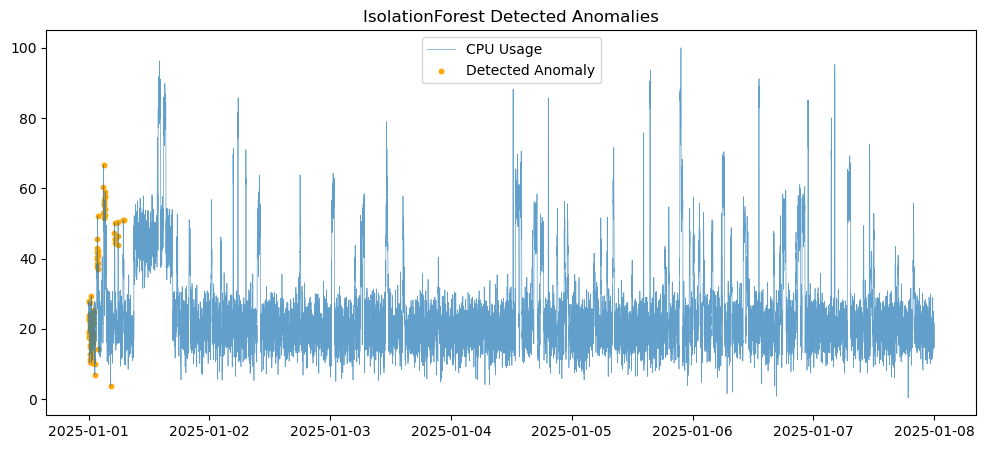

In [23]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

X = data[['cpu_usage', 'hour', 'is_business_hours', 'is_night', 'is_weekend']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = IsolationForest(contamination=0.01, random_state=42)
data['predicted_anomaly'] = model.fit_predict(X_scaled)
data['predicted_anomaly'] = data['predicted_anomaly'].map({1: 0, -1: 1})

print(confusion_matrix(data['anomaly'], data['predicted_anomaly']))
print(classification_report(data['anomaly'], data['predicted_anomaly']))

plt.figure(figsize=(12,5))
plt.plot(data['timestamp'], data['cpu_usage'], alpha=0.7, linewidth=0.5, label='CPU Usage')
plt.scatter(data[data['predicted_anomaly']==1]['timestamp'], data[data['predicted_anomaly']==1]['cpu_usage'],
            color='orange', s=10, label='Detected Anomaly')
plt.legend()
plt.title('IsolationForest Detected Anomalies')
plt.show()



=== Random Forest Classifier ===
[[1875   26]
 [  24   91]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1901
           1       0.78      0.79      0.78       115

    accuracy                           0.98      2016
   macro avg       0.88      0.89      0.89      2016
weighted avg       0.98      0.98      0.98      2016



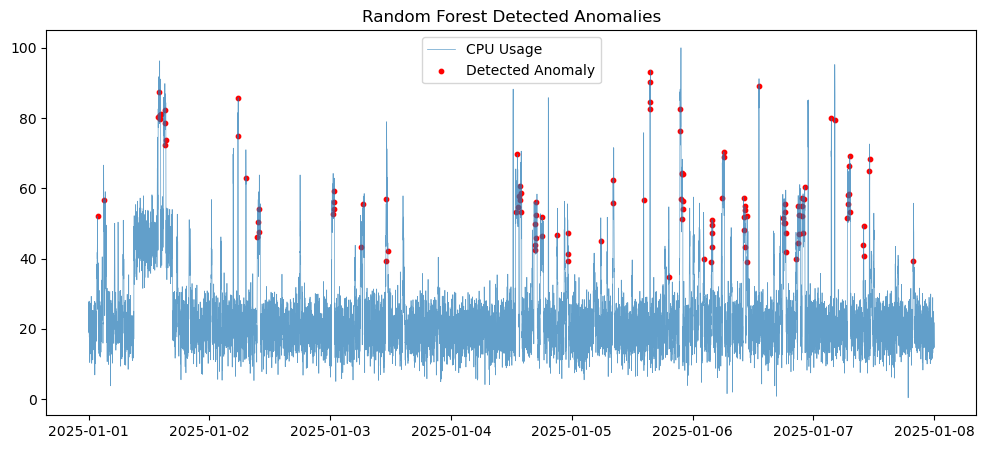

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Features and target
X = data[['cpu_usage', 'hour', 'is_business_hours', 'is_night', 'is_weekend']]
y = data['anomaly']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on test data
y_pred = rf_clf.predict(X_test)

# Evaluate
print("=== Random Forest Classifier ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualization (optional)
plt.figure(figsize=(12,5))
plt.plot(data['timestamp'], data['cpu_usage'], alpha=0.7, linewidth=0.5, label='CPU Usage')
plt.scatter(data.iloc[y_test.index][y_pred == 1]['timestamp'],
            data.iloc[y_test.index][y_pred == 1]['cpu_usage'],
            color='red', s=10, label='Detected Anomaly')
plt.legend()
plt.title('Random Forest Detected Anomalies')
plt.show()


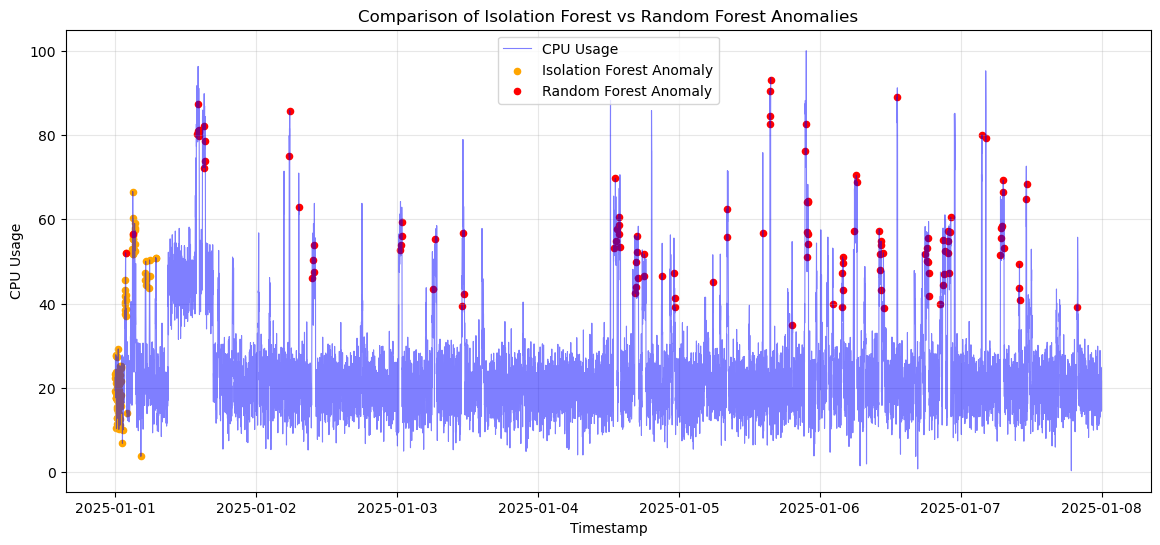

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(data['timestamp'], data['cpu_usage'], color='blue', alpha=0.5, linewidth=0.8, label='CPU Usage')

# Isolation Forest anomalies (orange)
plt.scatter(data[data['predicted_anomaly'] == 1]['timestamp'],
            data[data['predicted_anomaly'] == 1]['cpu_usage'],
            color='orange', s=20, label='Isolation Forest Anomaly')

# Random Forest anomalies (red)
plt.scatter(data.iloc[y_test.index][y_pred == 1]['timestamp'],
            data.iloc[y_test.index][y_pred == 1]['cpu_usage'],
            color='red', s=20, label='Random Forest Anomaly')

plt.title('Comparison of Isolation Forest vs Random Forest Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [36]:
import joblib

# Save your model
joblib.dump(model, 'model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("✅ Model and scaler saved!")

✅ Model and scaler saved!
